In [1]:
### Importing Libraries
import struct
import numpy as np
from array import array
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data=pd.read_csv('mnist_train.csv')

In [3]:
### We need to classify 6 and 9, using PCA. Constructing PCA and Bayes classifier from scratch. 
mydata=data[(data['label']==6) | (data['label']==9)]

In [4]:
T_train=mydata['label']

In [5]:
X_train=mydata.drop(columns='label')

In [6]:
def vectortoimg(v,show=True):
    plt.imshow(v.reshape(28, 28),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

In [7]:
X_train=X_train.as_matrix()

C:\Users\Mr.Khiladi\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Checking multiple training vectors by plotting images.
Be patient:


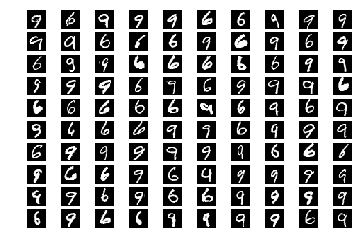

In [8]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure()
nrows=10
ncols=10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(X_train[np.random.randint(len(T_train))],show=False)
plt.show()

In [9]:
meanvector=np.mean(X_train,axis=0)


In [10]:
Z_train=X_train-meanvector

Checking multiple training vectors by plotting images.
Be patient:


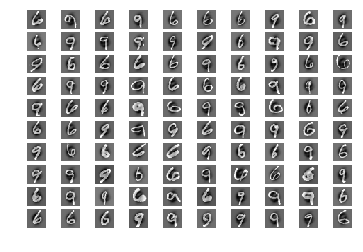

In [11]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure()
nrows=10
ncols=10
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(Z_train[np.random.randint(len(T_train))],show=False)
plt.show()

In [12]:
C_Train=np.cov(Z_train.T); print(np.shape(C_Train))

(784, 784)


In [13]:
Eigenvalues,Eigenvectors=np.linalg.eigh(C_Train)

In [14]:
np.argmax(Eigenvalues)  ## The Max (max important) Eigen Value is at the last 783 position. So last column / row is the eigen vector of max importance

783

In [15]:
## Next we have to determine whether columns or rows represent eigenvectors

In [16]:
row=Eigenvectors[-1,:];col=Eigenvectors[:,-1];
max(np.dot(C_Train,row)-(Eigenvalues[-1]*row))  ## Rows are not 
max(np.dot(C_Train,col)-(Eigenvalues[-1]*col))  #### matrix* EigenVector==EigenValue* EigenVector ,Therefore, Columns are EigenVectors

7.275957614183426e-11

In [17]:
Eigenvalues=np.flipud(Eigenvalues)
Eigenvectors=np.flipud(Eigenvectors.T)

In [18]:
row=Eigenvectors[0,:]
## Checking Again:
min(np.dot(C_Train,row)-(Eigenvalues[0]*row))  ## Rows are eigen vectors here 



-5.093170329928398e-11

In [19]:
np.allclose(np.dot(C_Train,row),Eigenvalues[0]*row)  ## Check 2

True

In [20]:
prin_comp=np.dot(Z_train,Eigenvectors.T)

In [21]:
T_train=np.array(T_train)

In [22]:
x=np.append(prin_comp[:,0:2],T_train.reshape(-1,1),axis=1)

In [23]:
pcadata=pd.DataFrame(x,columns=['pc1','pc2','labels'])

In [24]:
def Hist2D(mydata,mybins):
    min1=min(mydata["pc1"])
    min2=min(mydata["pc2"])
    max1=max(mydata["pc1"])
    max2=max(mydata["pc2"])
    
    
    HN=np.zeros(shape=(mybins,mybins)).astype('int32')
    HP=np.zeros(shape=(mybins,mybins)).astype('int32')
    row=[round(((mybins-1)*((xi-min1)/(max1-min1)))) for xi in mydata["pc1"]]
    col=[round(((mybins-1)*((xj-min2)/(max2-min2)))) for xj in mydata["pc2"]]
    for i in range(len(mydata)):
        if mydata.iloc[i,2]==6:
            HN[row[i],col[i]]+=1
        else:
            HP[row[i],col[i]]+=1
    return HN,HP
        

In [25]:
HN,HP=Hist2D(pcadata,32)

In [26]:
test_data=pd.read_csv("mnist_test.csv")
test_data=test_data[(test_data['label']==6) | (test_data['label']==9)]

In [27]:
test_data1=np.array(test_data.drop(['label'],axis=1))

In [29]:
pos_test=test_data1[1]

In [31]:
neg_test=test_data1[2]

In [32]:
mean_neg=neg_test-meanvector

In [33]:
mean_pos=pos_test-meanvector

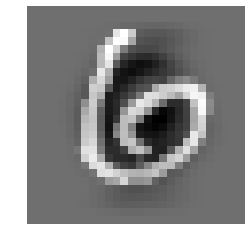

In [34]:
vectortoimg(mean_neg)

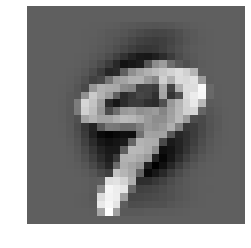

In [35]:
vectortoimg(mean_pos)

In [36]:
prin_comp_pos=np.dot(mean_pos,Eigenvectors.T)
prin_comp_neg=np.dot(mean_neg,Eigenvectors.T)

In [37]:
rp=np.dot(prin_comp_pos[0:2],Eigenvectors[0:2,:])
rn=np.dot(prin_comp_neg[0:2],Eigenvectors[0:2,:])

In [38]:
## Reconstruction of the images using first two principle components
recn=rn+meanvector
recp=rp+meanvector


In [40]:
def QueriesAcc(mydata,mybins,pc1_new,pc2_new):
    min1=min(mydata["pc1"])
    min2=min(mydata["pc2"])
    max1=max(mydata["pc1"])
    max2=max(mydata["pc2"])
    
    
    HN=np.zeros(shape=(mybins,mybins)).astype('int32')
    HP=np.zeros(shape=(mybins,mybins)).astype('int32')
    row=[round(((mybins-1)*((xi-min1)/(max1-min1)))) for xi in mydata["pc1"]]
    col=[round(((mybins-1)*((xj-min2)/(max2-min2)))) for xj in mydata["pc2"]]
    for i in range(len(mydata)):
        if mydata.iloc[i,2]==6:
            HN[row[i],col[i]]+=1
        else:
            HP[row[i],col[i]]+=1
    newrow=round(((mybins-1)*((pc1_new-min1)/(max1-min1)))).astype(int)
    newcol=round(((mybins-1)*((pc2_new-min2)/(max2-min2)))).astype(int)
    Probability=0
    Predicted=str()
    if HN[newrow,newcol] > HP[newrow,newcol]:
        Predicted=6
        Probability=HN[newrow,newcol]/(HN[newrow,newcol]+HP[newrow,newcol])
    elif HN[newrow,newcol] < HP[newrow,newcol]:
        Predicted=9
        Probability=HP[newrow,newcol]/(HN[newrow,newcol]+HP[newrow,newcol])
    else:
        Predicted=0
        Probability="Indeterminate"
    return Predicted
        

In [41]:
##Fdata-Negative
## Mdata=Positive
def BayesianClassifierAcc(Fdata,Mdata,newheight,newhandspan):
    fcov=np.cov(Fdata,rowvar=False)
    mcov=np.cov(Mdata,rowvar=False)
    Fcount=int(Fdata.shape[0])
    Mcount=int(Mdata.shape[0])
    Fdet=(np.linalg.det(fcov))**0.5
    Mdet=(np.linalg.det(mcov))**0.5
    fmean=np.mean(Fdata)
    mmean=np.mean(Mdata)
    x_fmean=np.subtract([newheight,newhandspan],fmean)
    x_mmean=np.subtract([newheight,newhandspan],mmean)
    f=Fcount*(1/(2*np.pi*Fdet))*(np.e**(-0.5*(np.matmul(np.matmul(x_fmean,np.linalg.inv(fcov)),x_fmean.T))))
    m=Mcount*(1/(2*np.pi*Mdet))*(np.e**(-0.5*(np.matmul(np.matmul(x_mmean,np.linalg.inv(mcov)),x_mmean.T))))
    if f>m:
        return 6
    elif f<m:
        return 9
    else:
        return 0   

    
    
    
    
    
    
    
    
    

In [42]:
Z_test=test_data1-meanvector

In [45]:
Z_test1=np.array(Z_test)

In [47]:
pca_test=np.dot(Z_test1,Eigenvectors.T)

In [49]:
accr_his=[]
for u in range(len(pca_test)):
    accr_his.append(QueriesAcc(pcadata,32,pca_test[u][0],pca_test[u][1]))
    
    
    
    

In [50]:
test_labels=np.array(test_data['label'])
test_labels

array([9, 9, 6, ..., 6, 9, 6], dtype=int64)

In [51]:
## Accuracy of Histogram Classifier
np.sum(accr_his==test_labels)/len(test_labels)

0.9761057447890188

In [53]:
accr_bay=[]
for u in range(len(pca_test)):
    accr_bay.append(BayesianClassifierAcc(pcadata[pcadata['labels']==6].drop(columns='labels'),pcadata[pcadata['labels']==9].drop(columns='labels'),pca_test[u][0],pca_test[u][1]))
    

In [54]:
### Accuracy of Bayes Classifier
np.sum(accr_bay==test_labels)/len(test_labels)

0.9796644636502287

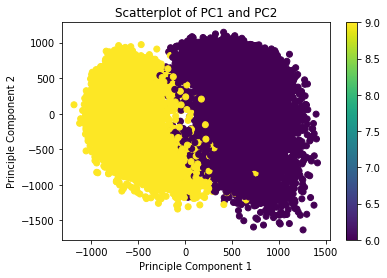

In [56]:
plt.scatter(pcadata['pc1'],pcadata['pc2'],c=pcadata['labels'])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Scatterplot of PC1 and PC2')
plt.colorbar()

